# Imports 

In [1]:
"""

pip install scipy
pip install h5py
pip install matplotlib
pip install opencv-python
pip install seaborn
pip install matplotlib
!pip install ipywidgets
pip install matplotlib install ipywidgets
pip install opencv-pythonjupyter nbextension enable --py widgetsnbextension
pip install ipython
pip install WordCloud
pip install geopy
pip install scipy
pip install plotly
pip install nbformat --upgrade
pip install folium
pip install geopandas
pip install scikit-learn   

"""

'\n\npip install scipy\npip install h5py\npip install matplotlib\npip install opencv-python\npip install seaborn\npip install matplotlib\n!pip install ipywidgets\npip install matplotlib install ipywidgets\npip install opencv-pythonjupyter nbextension enable --py widgetsnbextension\npip install ipython\npip install WordCloud\npip install geopy\npip install scipy\npip install plotly\npip install nbformat --upgrade\npip install folium\npip install geopandas\npip install scikit-learn   \n\n'

In [2]:

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from dotenv import load_dotenv
import os
import openai

from bs4 import BeautifulSoup
import re
import time
import pickle
import numpy as np 
import pandas as pd

from scrapifurs import utils
from scrapifurs.GPTinstructions import GPTinstructions

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.cluster.hierarchy import linkage, leaves_list

from geopy.geocoders import Nominatim
from geopy.distance import geodesic


import plotly.express as px



In [3]:
def get_lat_lon(locations):
    geolocator = Nominatim(user_agent="example.lastname@gmail.com")
    lat_lon_data = {}
    for location in tqdm(locations):
        location_data = geolocator.geocode(location)
        if location_data is not None:
            lat_lon_data[location] = (location_data.latitude, location_data.longitude)
        else:
            lat_lon_data[location] = (None, None)
    return lat_lon_data

def calculate_distances(lat_lon_data, target_loc_str):
    target_location = get_lat_lon([target_loc_str])[target_loc_str]
    if target_location[0] is None:
        raise ValueError("No latitude and longitude found for the provided location.")
    distances = {}
    for location, loc_lat_lon in lat_lon_data.items():
        if loc_lat_lon[0] is not None:
            distance = geodesic(target_location, loc_lat_lon).miles
            distances[location] = distance
        else:
            distances[location] = None
    return distances





def jaccard_similarity(str1, str2):
    set1 = set(str1.split())
    set2 = set(str2.split())
    union_length = len(set1.union(set2))
    if union_length == 0:
        return np.nan
    return len(set1.intersection(set2)) / union_length


class GPT_StringDataCleaner:
    def __init__(self, original_df, key_name, instructions, overwrite_cleaned_key = True, model="gpt-4"):
        self.original_df = original_df
        self.key_name = key_name
        self.instructions = instructions
        self.model = model
        self.clean_key = key_name + '_CLEANED_BY_GPT'
        self.overwrite_cleaned_key = overwrite_cleaned_key

    def send_to_gpt(self):
        self.unique_names = sorted(self.original_df[self.key_name].unique())

        messages = [{"role": "system", "content": self.instructions}]
        messages.append({"role": "user", "content": str(self.unique_names)})
        chat = openai.ChatCompletion.create(model=self.model, messages=messages)
        self.reply = chat.choices[0].message.content
    def test_lengths(self):
        print(f" len input is {len(self.unique_names)}, but len output is {len(cleaned_data)}")
    def process_data(self):
        cleaned_data =  eval(self.reply)
        
        if len(self.unique_names) != len(cleaned_data):
            print(f" len input is {len(self.unique_names)}, but len output is {len(cleaned_data)}")
            raise ValueError("Input and output lists must have the same length")

        temp_df = pd.DataFrame({self.key_name: self.unique_names, self.clean_key: cleaned_data})
        # delete cleaned key data if we want to overwrite
        if self.clean_key in self.original_df.columns and self.overwrite_cleaned_key:
            self.original_df = self.original_df.drop(self.clean_key, axis=1)
        if self.clean_key not in self.original_df.columns:
            merged_df = pd.merge(self.original_df, temp_df[[self.clean_key, self.key_name]],
                                 on=self.key_name, how='left')
            self.original_df[self.clean_key] = merged_df[self.clean_key]
            merged_df = None

        return self.original_df

### INIT API key,  intrucitons for GPT which can be saved as text files in the correct data/instrucitons dir of the package

In [11]:

# setup API key for chatGPT 
load_dotenv()  # take environment variables from .env.
os.environ["OPENAI_API_KEY"]  = os.getenv("OPENAI_API_KEY")
openai.api_key = os.environ["OPENAI_API_KEY"]




# Info_dict to set up all used variables

In [3]:
# setup basic variable as dict 
info_dict = {'init_url':'https://www.linkedin.com/',
             'save_password_dir':'/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/saved_cookies/',
             'start_url':'https://www.linkedin.com/search/results/people/?keywords=data%20scientist&origin=CLUSTER_EXPANSION&sid=fRq'}
info_dict['full_cookies_save_path'] = info_dict['save_password_dir']+os.sep+"linkedin_cookies.pkl"


# Scraping step

### create rules to trim text based on key workds and search characteristics
this willl help reduce the amount of data we pass to GPT API and reduce costs 

In [4]:
text_finder = utils.StringSectionExtractor()
text_finder.add_start_rule('search result pages', False)
text_finder.add_end_rule('Page \d+ of \d+', True)
text_finder.add_end_rule("these results helpful", False)
text_finder.add_end_rule("messaging overlay", False)

### INIT: chrome browser, login, save cookies (future login)

In [9]:


#init chrome 
chrome_options = Options()
chrome_options.add_argument("--disable-extensions")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=chrome_options)

driver.get(info_dict['init_url'])
time.sleep(1)
driver.get(info_dict['init_url'])
time.sleep(2)


# Load cookies if they exist
try:
    cookies = pickle.load(open(info_dict['full_cookies_save_path'], "rb"))
    for cookie in cookies:
        driver.add_cookie(cookie)
    driver.refresh()
    assert(not not cookies)# if empty try a different method
except:
    print("No cookies found. Manual login required.")
    # If not logged in
    input('Please login and press Enter to continue...')
    pickle.dump(driver.get_cookies(), open(info_dict['full_cookies_save_path'], "wb")) # save cookies after login
    



for this example must reduce window size to 25% (or implement scrolling with rescanning) to gather data. zooming out manually is necessary 

In [6]:
input('''set zoom to 25% for winow to see all website data that it needs, press enter to continue''')


set zoom to 25% for winow to see all website data that it needs, press enter to continue


''

#### navigate to the first page we want to scrape

In [10]:
driver.get(info_dict['start_url'])
all_text = []

#### scrape all the pages moving from one page to the next and save

In [11]:
f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/linked_in_search_saves/extractedLinkedinSearchDataRawText.pkl'
collect_n_pages = 60
n_times = np.random.uniform(12, 28, collect_n_pages)# randomize the wait times a little bit to prevent robotic like behavior
for k in n_times:
    time.sleep(k)
    url_text = utils.get_lxml_text(driver, remove_empty_lines=True)
    text_data = text_finder.extract(url_text)
    all_text.append(text_data)
    utils.click_next_button(driver)
    
utils.save_obj(all_text, f_name)
# with open(f_name, 'wb') as f:
#     pickle.dump(all_text, f)


In [14]:
# f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/linked_in_search_saves/extractedLinkedinSearchDataRawText.pkl'
# all_text = utils.load_obj(f_name)

## Some data is inconcsitant (empty pages etc) 

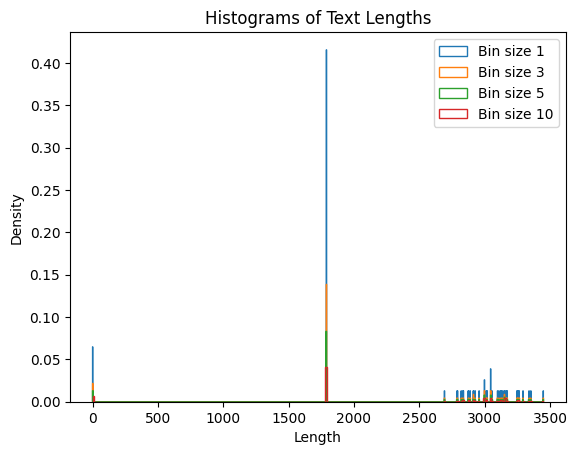

In [17]:
bin_widths = [1, 3, 5, 10]

data = [len(k) for k in all_text]
# Loop through the bin sizes and plot the histograms
for w in bin_widths:
    plt.hist([len(k) for k in all_text], bins=np.arange(min(data), max(data) + w, w),density=True, histtype='step', label=f'Bin size {w}')

plt.xlabel('Length')
plt.ylabel('Density')
plt.title('Histograms of Text Lengths')
plt.legend()
plt.show()

In [18]:

# Create similarity matrix
similarity_matrix = [[jaccard_similarity(doc1, doc2) for doc2 in all_text] for doc1 in all_text]




#### Create a heatmap to find scraped data that is inconsistnat with previous data. 

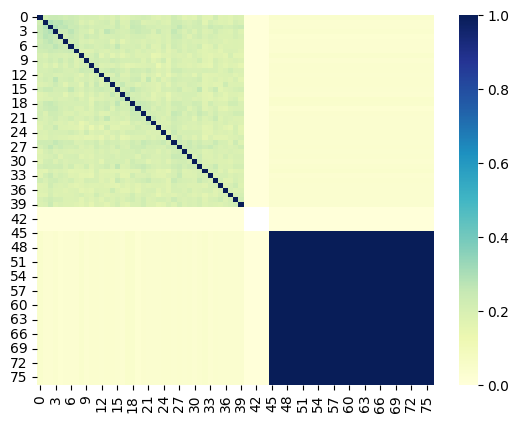

In [19]:
sns.heatmap(similarity_matrix, annot=False, cmap="YlGnBu")
plt.show()


only the first 39 pages have good data as you can see below

In [20]:
print(all_text[39][:200]+'\n\n___')# real data
print(all_text[40][:200]+'\n\n___')# empty
print(all_text[-1][:200]+'\n\n___')# no search results

.
About 621,000 results
          Status is offline
Jane Liang, PhDView Jane Liang,  PhD’s profile
• 2nd2nd degree connection
• 2nd2nd degree connection
Sr. Data Scientist at Intuit
Los Angeles Metrop

___


___
.
      No results found
  Try shortening or rephrasing your search.
          Edit search
                        About
                        Accessibility
                        Talent Solutions


___


# Chat GPT extract scraped data

#### Get instructions to make sure consistent cleaning instructions from GPT
note: instructions were tested in chatGPT and then once I verified the outcome, I asked chatGPT to then give me clear instructions for reproducibility

In [22]:
# allow you to save instructions to append ot the beginning of a GPT command based on the txt files in 
# the data directory (or set a custom directory). modular for the many different commands and instructions 
# we will need. 
instructions = GPTinstructions()

# # Print all instructions keys
# instructions.print_instructions()
gpt_instructions = instructions.get_instruction("linkedinSearchExtractNamesDF")

print(gpt_instructions)

Extract the names: Please look for patterns indicating a person's name. Names are usually proper nouns and are generally the first information provided in each data point.

    Find the job titles: Please identify each person's job title. This information follows the name and often contains phrases such as 'Data Scientist', 'Neuroscientist', 'Senior Associate Data Scientist', or a variant that includes the role and any additional qualifiers.

    Identify the job location: This information typically follows the job title and is usually a city or metropolitan area, such as 'Pasadena, CA' or 'Los Angeles Metropolitan Area'.

    Find the company names: The company names usually follow the job location. In case there is no current company mentioned, or the person is actively seeking a job, make a note of that by using placeholders like 'None (Job Seeking)' or 'None (No Company Mentioned)'.

    Construct the dictionary: Organize all the extracted information into a dictionary format where

#### pull out data using CHAT GPT API

In [ ]:
# f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/linked_in_search_saves/extractedLinkedinSearchDataRawText.pkl'
# all_text = utils.load_obj(f_name)

In [23]:
text_2_process = all_text[:39] # filtered based on above analysis



In [56]:
columns = ["Name", "Job Titles", "Job Location", "Company Name"]
df = pd.DataFrame(columns=columns)
all_chats = []# just in case we get abnormal results lets save all our raw chat outputs

for kk, gpt_text in enumerate(tqdm(text_2_process)):
    messages = [ {"role": "system", "content": gpt_instructions} ]
    messages.append({"role": "user", "content": gpt_text})
    chat = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=messages)
    all_chats.append(chat)
    try:
        reply = chat.choices[0].message.content
        tmp1 = reply.split('##BEGIN##')[-1].split('##END##')[0]
        DF_TEMP = None
        exec(tmp1);
        DF_TEMP = pd.DataFrame(DF_TEMP)
        df= pd.concat([df, DF_TEMP], ignore_index=True)
    except Exception as e:
        warning_msg = f"An exception occurred at index {kk} with content {gpt_text[:50]}. Error details: {str(e)}"
        warnings.warn(warning_msg)




#### Save data as pickle or csv

In [30]:
f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/pandas_df/final_df_data_scientist_search_v1'
utils.save_obj(df, f_name+'.pkl', pickle.HIGHEST_PROTOCOL)
# df.to_csv(f_name+'.csv', index=False)



# data cleaning

#### Load data frame (if not already in memory) and drop names for privacy

In [4]:
df = utils.load_obj('/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/pandas_df/final_df_data_scientist_search_v1.pkl')
df = df.drop('Name', axis=1)
df


,Job Titles,Job Location,Company Name
0,Incoming Data Scientist at Chevron | USC Alum,"Los Angeles, CA",Chevron
1,Data Scientist at eBay,"Los Angeles, CA",eBay
2,Data Scientist at Twitter,Los Angeles Metropolitan Area,Twitter
3,Data Scientist | Petroleum Engineer,Los Angeles Metropolitan Area,Phillips 66
4,Data Scientist at Snap Inc.,Los Angeles Metropolitan Area,Snap Inc.
...,...,...,...
373,Data Scientist,Los Angeles Metropolitan Area,Data Scientist II at Nordstrom
374,Data Scientist,"Los Angeles, CA",Data Scientist at BCG GAMMA
375,Data Scientist,"Los Angeles, CA",Data Scientist at Rule14 LLC
376,Data Analyst | Data Scientist,Los Angeles Metropolitan Area,None (No Company Mentioned)


## duplicate locations
this is overkill since we can just look at the list but this is an example of what we could do for a larger list where this visualization may be more useful

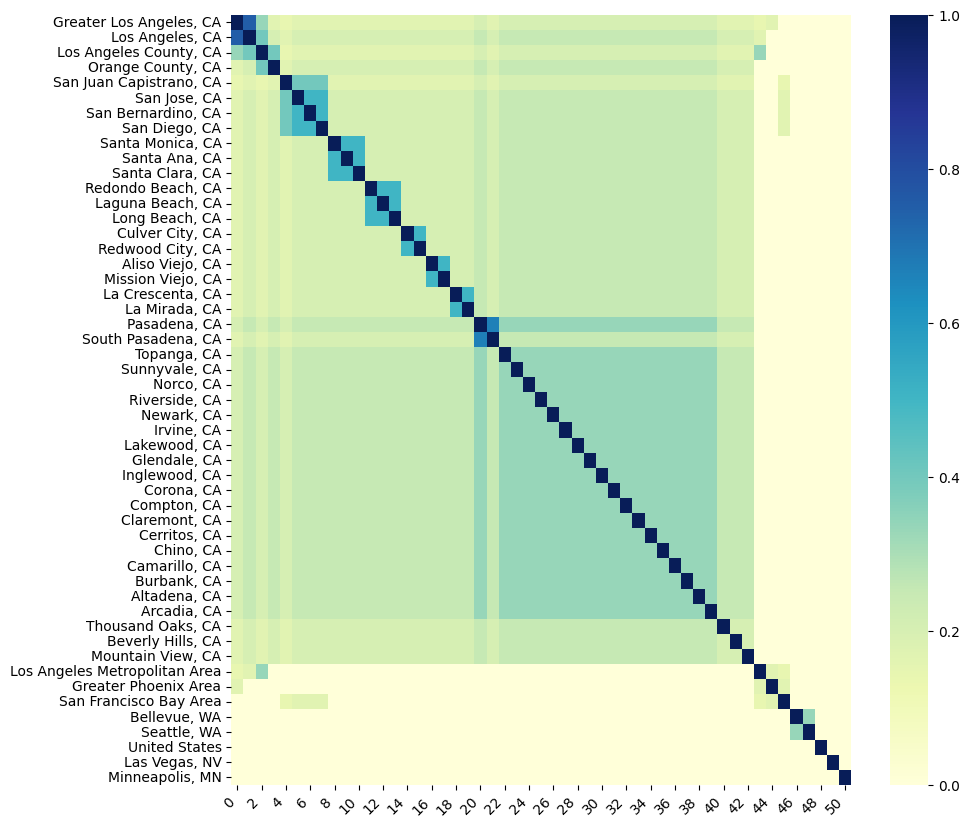

In [9]:
data_in = sorted(df['Job Location'].unique())

# Assuming similarity_matrix is your similarity matrix
similarity_matrix = [[jaccard_similarity(doc1, doc2) for doc2 in data_in] for doc1 in data_in]

# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='average')
order = leaves_list(Z)

# Reorder the rows and columns of the similarity matrix based on clustering
reordered_similarity_matrix = [[similarity_matrix[i][j] for j in order] for i in order]
reordered_data_in = [data_in[i] for i in order]

# Plot the reordered similarity matrix
plt.figure(figsize=[10, 10])
sns.heatmap(reordered_similarity_matrix, annot=False, cmap="YlGnBu", yticklabels=reordered_data_in)
plt.xticks(rotation=45, ha="right") # Optionally, to rotate x labels for better visibility
plt.show()



again overkill to use GPT here but it could be useful to identify locations we are not familiar with that may represent the same area. more useful for larger dataset wehre there are 500+ unique locations

In [12]:

locations_in = '\n'.join(sorted(df['Job Location'].unique()))

intructions_cleaning = """
Check this data, are there any locations that could be considered the the same location. 
I want all places that mean the same thing to be the exact same string.
Point out any duplicates that dont have the same string (either due to case-sensitive, difference in spelling or from different terminologies)
for each, set up suplicate locations with different name format the output as a python list. 
"""
messages = [ {"role": "system", "content": intructions_cleaning} ]
messages.append({"role": "user", "content": locations_in})
chat = openai.ChatCompletion.create(model="gpt-4", messages=messages)



In [13]:
print(chat.choices[0].message.content)

The places that can be considered the same are 

1. "Greater Los Angeles, CA", "Los Angeles County, CA", "Los Angeles Metropolitan Area" and "Los Angeles, CA"  

2. "San Francisco Bay Area" can include "Mountain View, CA", "Newark, CA", "Redwood City, CA", "San Jose, CA", "Santa Clara, CA", "Sunnyvale, CA", although not always.

The Python list format of these places would be: 

duplicate_locations = [["Greater Los Angeles, CA", "Los Angeles County, CA", "Los Angeles Metropolitan Area", "Los Angeles, CA"], ["San Francisco Bay Area", "Mountain View, CA", "Newark, CA", "Redwood City, CA", "San Jose, CA", "Santa Clara, CA", "Sunnyvale, CA"]]



We can see that there are 7 strong clusters and none have any points outside their cluster. we can visually inspect each cluster to identifiy any possible outliers. 

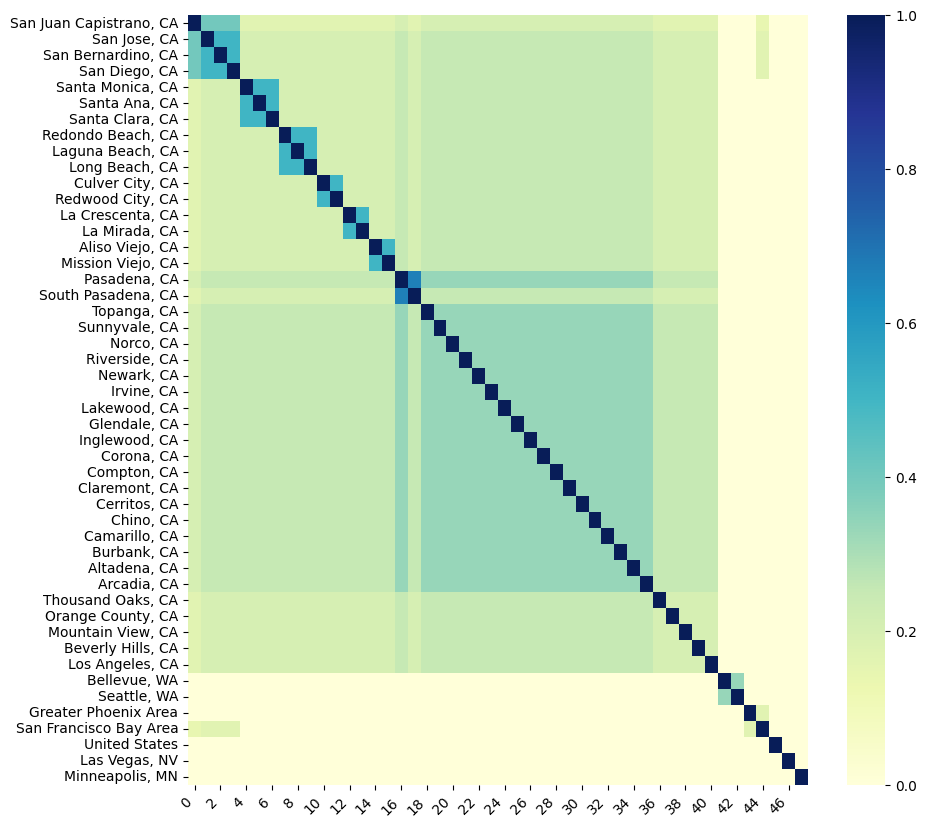

In [74]:
# Define the list of duplicates
duplicates = ["Greater Los Angeles, CA", "Los Angeles County, CA", "Los Angeles Metropolitan Area", "Los Angeles, CA"]

# Replace all instances of values in duplicates list with set_value
df['Job Location'] = df['Job Location'].replace(duplicates, "Los Angeles, CA")
locations_in = '\n'.join(sorted(df['Job Location'].unique()))

data_in = sorted(df['Job Location'].unique())

# Assuming similarity_matrix is your similarity matrix
similarity_matrix = [[jaccard_similarity(doc1, doc2) for doc2 in data_in] for doc1 in data_in]

# Perform hierarchical clustering
Z = linkage(similarity_matrix, method='average')
order = leaves_list(Z)

# Reorder the rows and columns of the similarity matrix based on clustering
reordered_similarity_matrix = [[similarity_matrix[i][j] for j in order] for i in order]
reordered_data_in = [data_in[i] for i in order]

# Plot the reordered similarity matrix
plt.figure(figsize=[10, 10])
sns.heatmap(reordered_similarity_matrix, annot=False, cmap="YlGnBu", yticklabels=reordered_data_in)
plt.xticks(rotation=45, ha="right") # Optionally, to rotate x labels for better visibility
plt.show()



## the job title and company data are messy, some people put both the title and the company in the same idenfier (e.g. under company they put , "data scientist at Amazon") 

In [19]:

instructions = """
for this list of names output a python list with only the company names and no other extraneous details.
if names appear insoncistant (e.g. amazon and AMAZON) change them to all be the same name

so for example "Data Scientist at Aviana Global Technologies, Inc." woudl return "Aviana Global Technologies"
every value of the input list should have a corresponding value for the output. 
"""

cleaner = GPT_StringDataCleaner(df, 'Company Name', instructions)
cleaner.send_to_gpt()

        
# print(cleaner.reply)
exec("cleaned_data = "+cleaner.reply)
len(cleaned_data), len(cleaner.unique_names)        

(267, 267)

In [20]:
df = cleaner.process_data()
df


,Job Titles,Job Location,Company Name,Company Name_CLEANED_BY_GPT
0,Incoming Data Scientist at Chevron | USC Alum,"Los Angeles, CA",Chevron,Chevron
1,Data Scientist at eBay,"Los Angeles, CA",eBay,eBay
2,Data Scientist at Twitter,Los Angeles Metropolitan Area,Twitter,Twitter
3,Data Scientist | Petroleum Engineer,Los Angeles Metropolitan Area,Phillips 66,Phillips 66
4,Data Scientist at Snap Inc.,Los Angeles Metropolitan Area,Snap Inc.,Snap Inc.
...,...,...,...,...
373,Data Scientist,Los Angeles Metropolitan Area,Data Scientist II at Nordstrom,Nordstrom
374,Data Scientist,"Los Angeles, CA",Data Scientist at BCG GAMMA,BCG GAMMA
375,Data Scientist,"Los Angeles, CA",Data Scientist at Rule14 LLC,Rule14 LLC
376,Data Analyst | Data Scientist,Los Angeles Metropolitan Area,None (No Company Mentioned),None


# location info and cleaning 

In [77]:
target_loc_str = ['hollywood california']
target_location = get_lat_lon(target_loc_str)
print(target_location)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

{'hollywood california': (34.0980031, -118.329523)}


In [78]:
locations = locations = df['Job Location'].unique()
target_loc_str = 'hollywood california' # home location 
lat_lon_data = get_lat_lon(locations)
distances = calculate_distances(lat_lon_data, target_loc_str) # distance from your home location


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


In [95]:
# print(pd.DataFrame(lat_lon_data).T)
lat_lon_df = pd.DataFrame(lat_lon_data).T.reset_index()
lat_lon_df.columns = ['Job Location', 'latitude', 'longitude']
lat_lon_df['distance_to_target_miles'] = list(distances.values())




In [100]:
if 'latitude' in df.columns:
    df = df.drop(columns=['latitude', 'longitude', 'distance_to_target_miles'])

# Merge the two dataframes on the 'Job Location' column.
merged_df = None
merged_df = pd.merge(df, lat_lon_df[['Job Location', 'latitude', 'longitude', 'distance_to_target_miles']],
                     on='Job Location', how='left')

df['latitude'] = merged_df['latitude']
df['longitude'] = merged_df['longitude']
df['distance_to_target_miles'] = merged_df['distance_to_target_miles']
merged_df = None
df


,Job Titles,Job Location,Company Name,Company Name_CLEANED_BY_GPT,latitude,longitude,distance_to_target_miles
0,Incoming Data Scientist at Chevron | USC Alum,"Los Angeles, CA",Chevron,Chevron,34.053691,-118.242766,5.838454
1,Data Scientist at eBay,"Los Angeles, CA",eBay,eBay,34.053691,-118.242766,5.838454
2,Data Scientist at Twitter,"Los Angeles, CA",Twitter,Twitter,34.053691,-118.242766,5.838454
3,Data Scientist | Petroleum Engineer,"Los Angeles, CA",Phillips 66,Phillips 66,34.053691,-118.242766,5.838454
4,Data Scientist at Snap Inc.,"Los Angeles, CA",Snap Inc.,Snap Inc.,34.053691,-118.242766,5.838454
...,...,...,...,...,...,...,...
373,Data Scientist,"Los Angeles, CA",Data Scientist II at Nordstrom,Nordstrom,34.053691,-118.242766,5.838454
374,Data Scientist,"Los Angeles, CA",Data Scientist at BCG GAMMA,BCG GAMMA,34.053691,-118.242766,5.838454
375,Data Scientist,"Los Angeles, CA",Data Scientist at Rule14 LLC,Rule14 LLC,34.053691,-118.242766,5.838454
376,Data Analyst | Data Scientist,"Los Angeles, CA",None (No Company Mentioned),None,34.053691,-118.242766,5.838454


### check no distances are crazy or wrong

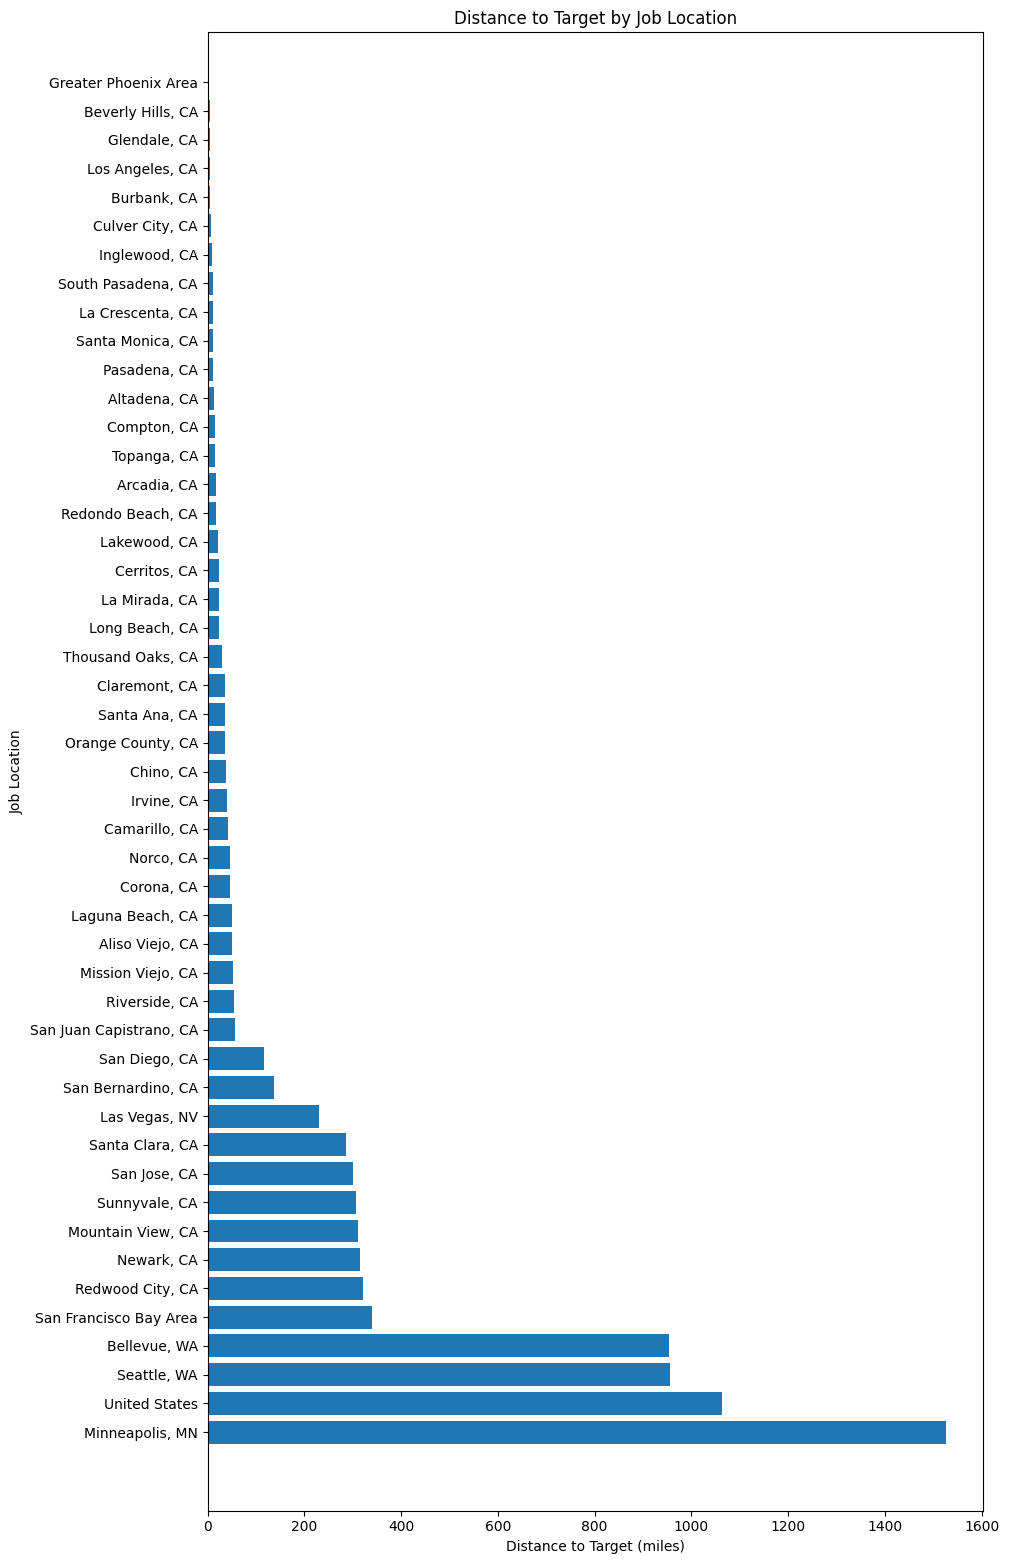

In [105]:


# Keep only unique combinations of 'Job Location' and 'distance_to_target_miles' and sort # location info and cleaning 
df_unique = df.drop_duplicates(subset=['Job Location', 'distance_to_target_miles'])
df_unique = df_unique.sort_values('distance_to_target_miles', ascending=False) # Change to ascending=True if you want it in the opposite order


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, len(df_unique) * 0.4)) # Adjust the size as needed

# Bar plot
ax.barh(df_unique['Job Location'], df_unique['distance_to_target_miles'])

# Label the axes
ax.set_xlabel('Distance to Target (miles)')
ax.set_ylabel('Job Location')

# Add a title
ax.set_title('Distance to Target by Job Location')

# Display the plot
plt.show()

In [106]:
f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/pandas_df/final_df_data_scientist_search_v2'
utils.save_obj(df, f_name+'.pkl', pickle.HIGHEST_PROTOCOL)
df.to_csv(f_name+'.csv', index=False)


# some data exploration

In [4]:
f_name = '/Users/phil/Dropbox/GITHUB/DATA/scrapifurs/pandas_df/final_df_data_scientist_search_v2'
df = utils.load_obj(f_name)
df


,Job Titles,Job Location,Company Name,Company Name_CLEANED_BY_GPT,latitude,longitude,distance_to_target_miles
0,Incoming Data Scientist at Chevron | USC Alum,"Los Angeles, CA",Chevron,Chevron,34.053691,-118.242766,5.838454
1,Data Scientist at eBay,"Los Angeles, CA",eBay,eBay,34.053691,-118.242766,5.838454
2,Data Scientist at Twitter,"Los Angeles, CA",Twitter,Twitter,34.053691,-118.242766,5.838454
3,Data Scientist | Petroleum Engineer,"Los Angeles, CA",Phillips 66,Phillips 66,34.053691,-118.242766,5.838454
4,Data Scientist at Snap Inc.,"Los Angeles, CA",Snap Inc.,Snap Inc.,34.053691,-118.242766,5.838454
...,...,...,...,...,...,...,...
373,Data Scientist,"Los Angeles, CA",Data Scientist II at Nordstrom,Nordstrom,34.053691,-118.242766,5.838454
374,Data Scientist,"Los Angeles, CA",Data Scientist at BCG GAMMA,BCG GAMMA,34.053691,-118.242766,5.838454
375,Data Scientist,"Los Angeles, CA",Data Scientist at Rule14 LLC,Rule14 LLC,34.053691,-118.242766,5.838454
376,Data Analyst | Data Scientist,"Los Angeles, CA",None (No Company Mentioned),None,34.053691,-118.242766,5.838454


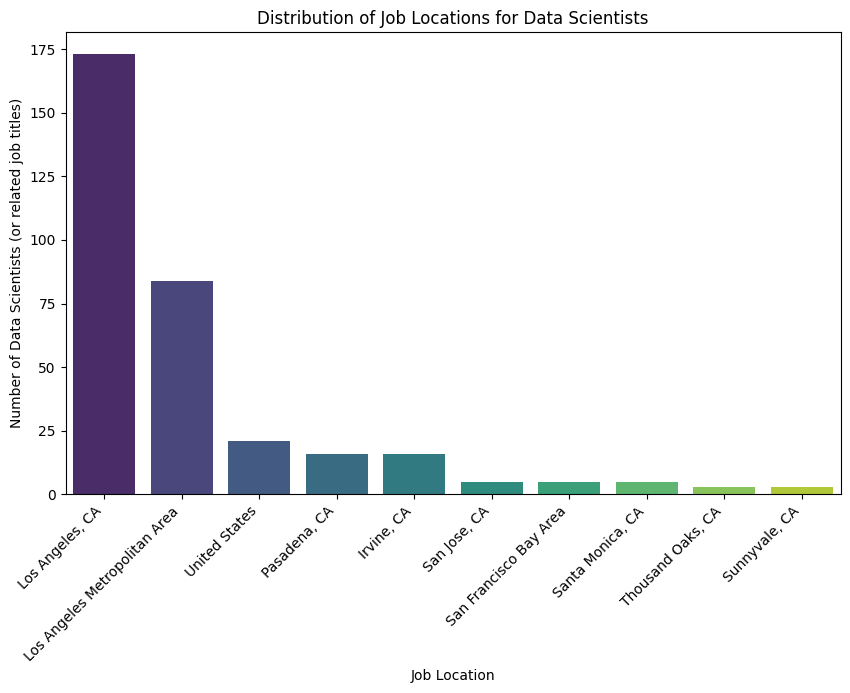

In [7]:

# Getting the distribution of job locations
job_location_counts = df['Job Location'].value_counts().nlargest(10)

# Plotting the distribution of job locations
plt.figure(figsize=(10, 6))
sns.barplot(x=job_location_counts.index, y=job_location_counts.values, palette="viridis")
plt.title('Distribution of Job Locations for Data Scientists')
plt.xlabel('Job Location')
plt.ylabel('Number of Data Scientists (or related job titles)')
plt.xticks(rotation=45, ha="right")
plt.show()


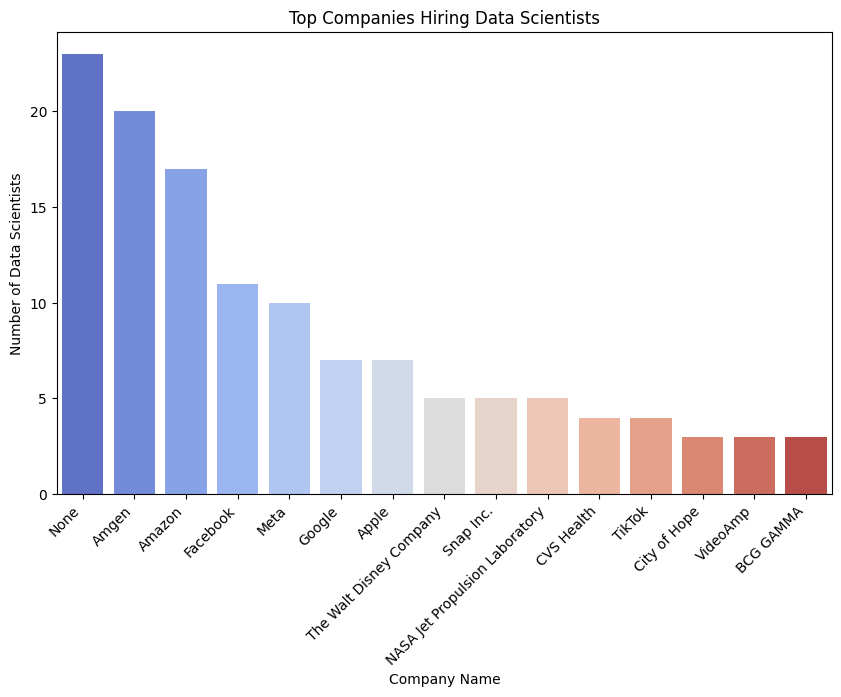

In [8]:
# Getting the top companies hiring data scientists
top_companies_counts = df['Company Name_CLEANED_BY_GPT'].value_counts().nlargest(15)
# top_companies_counts = df['Company Name'].value_counts().nlargest(15)


# Plotting the top companies hiring data scientists
plt.figure(figsize=(10, 6))
sns.barplot(x=top_companies_counts.index, y=top_companies_counts.values, palette="coolwarm")
plt.title('Top Companies Hiring Data Scientists')
plt.xlabel('Company Name')
plt.ylabel('Number of Data Scientists')
plt.xticks(rotation=45, ha="right")
plt.show()


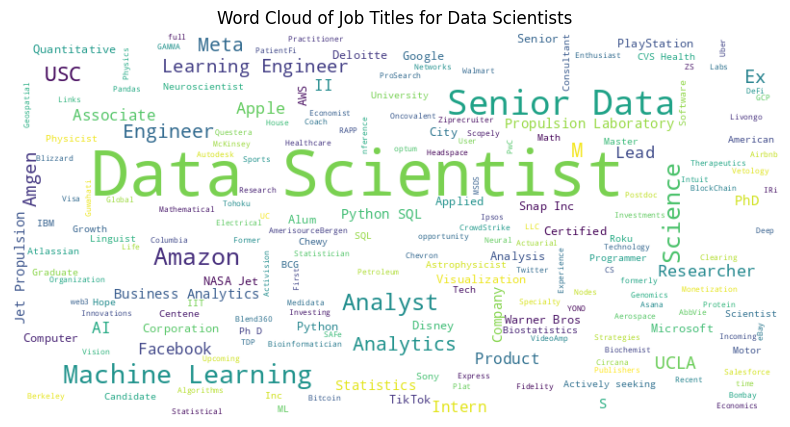

In [9]:
from wordcloud import WordCloud

# Concatenating all the job titles into a single string
job_titles_text = " ".join(title for title in df['Job Titles'])

# Creating a word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(job_titles_text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Job Titles for Data Scientists')
plt.show()


# _____ 

# making some maps of the data

In [5]:
target_loc_str = ['hollywood california']
target_location = get_lat_lon(target_loc_str)
print(target_location)
home_location = target_location[target_loc_str[0]]
home_location
# home_location = (34.0980031, -118.329523)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

{'hollywood california': (34.0980031, -118.329523)}


(34.0980031, -118.329523)

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

def get_top_n_companies(df, column_name, n=20):
    """Retrieve the top n companies based on occurrence."""
    return df[column_name].value_counts().nlargest(n).index

def create_grouped_data(df, column_name):
    """Group data by company name and create aggregated information."""
    grouped_counts = df.groupby(column_name).size()
    companies_text = '<br>'.join([f'{company} (Count: {count})' for company, count in grouped_counts.items()])
    total_count = grouped_counts.sum()
    return {'companies': companies_text, 'count': total_count}

def get_color_scale(breakpoints, cmap_name='turbo'):
    """Generate a custom color scale based on provided breakpoints using a colormap."""
    cmap = plt.get_cmap(cmap_name)
    normalized_breakpoints = (np.log(breakpoints) - np.log(breakpoints[0])) / (np.log(breakpoints[-1]) - np.log(breakpoints[0]))
    color_values = [cmap(value) for value in normalized_breakpoints]
    color_strings = [f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})" for r, g, b, _ in color_values]
    return list(zip(normalized_breakpoints, color_strings))

# Assuming df is loaded here as your DataFrame
column_name = 'Company Name_CLEANED_BY_GPT'
top_companies = get_top_n_companies(df, column_name)
df_filtered = df[df[column_name].isin(top_companies)]

grouped_data = df_filtered.groupby(['latitude', 'longitude']).apply(lambda x: create_grouped_data(x, column_name)).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:<br>{x['companies']}")

breakpoints = [1, 2, 3, 4, 5, 10, 25, 50, 100]
scatter_trace = go.Scattermapbox(
    lat=grouped_data['latitude'],
    lon=grouped_data['longitude'],
    text=grouped_data['hover_text'],
    mode='markers',
    marker=dict(
        color=np.log(grouped_data['data'].apply(lambda x: x['count'])),
        opacity=0.6,
        size=40,
        colorscale=get_color_scale(breakpoints),
        cmin=np.log(breakpoints[0]),
        cmax=np.log(breakpoints[-1]),
        colorbar=dict(
            title="Log scale company count",
            tickvals=np.log(breakpoints),
            ticktext=breakpoints
        )
    ),
    showlegend=False
)

home_location = (34.0980031, -118.329523)
home_trace = go.Scattermapbox(
    lat=[home_location[0]],
    lon=[home_location[1]],
    text=['HOME'],
    mode='text',
    showlegend=False
)

layout = go.Layout(
    mapbox=dict(
        style="carto-positron",
        center={"lat": home_location[0], "lon": home_location[1]},
        zoom=2.5
    ),
    title="Job Locations Across the US"
)

fig = go.Figure(data=[scatter_trace, home_trace], layout=layout)
fig.show()


In [24]:
import pandas as pd
import plotly.graph_objects as go

import copy

# Copy the dataframe
df_copy = copy.deepcopy(df)

# Find the counts of each company
company_counts = df_copy['Company Name_CLEANED_BY_GPT'].value_counts()

# Identify the top n companies
top_companies = company_counts.nlargest(20).index

# Keep only the rows corresponding to the top companies
df_copy = df_copy[df_copy['Company Name_CLEANED_BY_GPT'].isin(top_companies)]

# Identify companies that appear only once
single_entry_companies = company_counts[company_counts == 1].index

# # Replace those company names with "Other"
# df_copy['Company Name_CLEANED_BY_GPT'] = df_copy['Company Name_CLEANED_BY_GPT'].apply(lambda x: " _Other_" if x in single_entry_companies else x)


def create_data(x):
    companies_and_counts = x.groupby('Company Name_CLEANED_BY_GPT').size()
    companies_text = '<br>'.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    total_count = companies_and_counts.sum() # Sum of all counts
    return {'companies': companies_text, 'count': total_count}

grouped_data = df_copy.groupby(['latitude', 'longitude']).apply(create_data).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:<br>{x['companies']}")


scale_factor = 1
grouped_data['count_scaled'] = grouped_data['data'].apply(lambda x: x['count']) * scale_factor


grouped_data

# Create Scattermapbox trace
scatter_trace = go.Scattermapbox(
    lat=grouped_data['latitude'],
    lon=grouped_data['longitude'],
    text=grouped_data['hover_text'],
    mode='markers',
    marker=dict(
        color=np.log(grouped_data['count_scaled']),
        opacity=0.6,
        size = 40,
        colorscale='Jet', # Choose a color scale
        colorbar=dict(title="Log scale company count"), # Add a title to the color bar
        
    ),
    showlegend=False
)

# Add 'HOME'
home_location = (34.0980031, -118.329523)
home_trace = go.Scattermapbox(
    lat=[home_location[0]],
    lon=[home_location[1]],
    text=['HOME'],
    mode='text',
    showlegend=False
)

# Create Layout
layout = go.Layout(
    mapbox=dict(
        style="carto-positron",
        center={"lat": home_location[0], "lon": home_location[1]},
        zoom=2.5
    ),
    title="Job Locations Across the US (Unfiltered)"
)

# Create the figure and add the traces
fig = go.Figure(data=[scatter_trace, home_trace], layout=layout)

# Show the figure
fig.show()




In [38]:
import pandas as pd
import plotly.graph_objects as go

import copy

# Copy the dataframe
df_copy = copy.deepcopy(df)

# Find the counts of each company
company_counts = df_copy['Company Name_CLEANED_BY_GPT'].value_counts()

# Identify the top n companies
top_companies = company_counts.nlargest(20).index

# Keep only the rows corresponding to the top companies
df_copy = df_copy[df_copy['Company Name_CLEANED_BY_GPT'].isin(top_companies)]

# Identify companies that appear only once
single_entry_companies = company_counts[company_counts == 1].index

# # Replace those company names with "Other"
# df_copy['Company Name_CLEANED_BY_GPT'] = df_copy['Company Name_CLEANED_BY_GPT'].apply(lambda x: " _Other_" if x in single_entry_companies else x)


def create_data(x):
    companies_and_counts = x.groupby('Company Name_CLEANED_BY_GPT').size()
    companies_text = '<br>'.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    total_count = companies_and_counts.sum() # Sum of all counts
    return {'companies': companies_text, 'count': total_count}

grouped_data = df_copy.groupby(['latitude', 'longitude']).apply(create_data).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:<br>{x['companies']}")


scale_factor = 1
grouped_data['count_scaled'] = grouped_data['data'].apply(lambda x: x['count']) * scale_factor


import numpy as np
import plotly.graph_objects as go

# Custom color scale using the Jet color map
# Define RGB values directly based on Jet colors
color_values = [
    "rgb(0, 0, 127)",     # 1
    "rgb(0, 0, 255)",     # 2
    "rgb(0, 127, 255)",   # 3
    "rgb(0, 255, 255)",   # 4
    "rgb(127, 255, 0)",   # 5
    "rgb(255, 255, 0)",   # 10
    "rgb(255, 127, 0)",   # 25
    "rgb(255, 0, 0)",     # 50
    "rgb(127, 0, 0)"      # 100
]

# Create a color scale based on normalized log values of breakpoints
breakpoints = [1, 2, 3, 4, 5, 10, 25, 50, 100]
normalized_log_breakpoints = (np.log(breakpoints) - np.log(breakpoints[0])) / (np.log(breakpoints[-1]) - np.log(breakpoints[0]))
color_scale = list(zip(normalized_log_breakpoints, color_values))

# Create Scattermapbox trace with custom color scale and colorbar
scatter_trace = go.Scattermapbox(
    lat=grouped_data['latitude'],
    lon=grouped_data['longitude'],
    text=grouped_data['hover_text'],
    mode='markers',
    marker=dict(
        color=np.log(grouped_data['count_scaled']),
        opacity=0.6,
        size=20,
        colorscale=color_scale,  # Use the custom color scale
        cmin=np.log(breakpoints[0]),
        cmax=np.log(breakpoints[-1]),
        colorbar=dict(
            title="Log scale company count",
            tickvals=np.log(breakpoints),
            ticktext=breakpoints
        )
    ),
    showlegend=False
)


# Add 'HOME'
home_location = (34.0980031, -118.329523)
home_trace = go.Scattermapbox(
    lat=[home_location[0]],
    lon=[home_location[1]],
    text=['HOME'],
    mode='text',
    showlegend=False
)

# Create Layout
layout = go.Layout(
    mapbox=dict(
        style="carto-positron",
        center={"lat": home_location[0], "lon": home_location[1]},
        zoom=2.5
    ),
    title="Job Locations Across the US (Unfiltered)"
)

# Create the figure and add the traces
fig = go.Figure(data=[scatter_trace, home_trace], layout=layout)

# Show the figure
fig.show()




In [40]:
import numpy as np
import matplotlib.pyplot as plt

def get_color_scale(breakpoints, cmap_name='turbo'):
    """
    Generate a custom color scale for plotting based on given breakpoints and a colormap.
    
    Parameters:
    - breakpoints: List of numerical values for breakpoints.
    - cmap_name: Name of a matplotlib colormap.
    
    Returns:
    - A list of tuples containing normalized log breakpoints and color values in RGB format.
    """
    
    # Get the colormap
    cmap = plt.get_cmap(cmap_name)
    
    # Normalize breakpoints to the range [0,1] for colormap
    normalized_breakpoints = (np.log(breakpoints) - np.log(breakpoints[0])) / (np.log(breakpoints[-1]) - np.log(breakpoints[0]))
    
    # Get the colors from the colormap
    color_values = [cmap(value) for value in normalized_breakpoints]
    
    # Convert RGBA values to the "rgb(R, G, B)" format
    color_values = [f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})" for r, g, b, _ in color_values]
    
    return list(zip(normalized_breakpoints, color_values))



[(0.0, 'rgb(48, 18, 59)'),
 (0.15051499783199057, 'rgb(70, 122, 242)'),
 (0.23856062735983122, 'rgb(45, 180, 241)'),
 (0.30102999566398114, 'rgb(24, 215, 202)'),
 (0.3494850021680094, 'rgb(32, 233, 172)'),
 (0.5, 'rgb(164, 252, 59)'),
 (0.6989700043360187, 'rgb(253, 166, 49)'),
 (0.8494850021680093, 'rgb(221, 60, 7)'),
 (1.0, 'rgb(122, 4, 2)')]

In [41]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def get_top_n_companies(df, column_name, n=20):
    """Get top n companies based on their counts."""
    company_counts = df[column_name].value_counts()
    return company_counts.nlargest(n).index

def create_grouped_data(df, column_name):
    """Create grouped data for plotting."""
    companies_and_counts = df.groupby(column_name).size()
    companies_text = '<br>'.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    total_count = companies_and_counts.sum()
    return {'companies': companies_text, 'count': total_count}

def get_color_scale(breakpoints):
    """Generate a custom color scale for plotting."""
    color_values = [
        "rgb(0, 0, 127)", "rgb(0, 0, 255)", "rgb(0, 127, 255)", "rgb(0, 255, 255)",
        "rgb(127, 255, 0)", "rgb(255, 255, 0)", "rgb(255, 127, 0)", "rgb(255, 0, 0)", "rgb(127, 0, 0)"
    ]
    normalized_log_breakpoints = (np.log(breakpoints) - np.log(breakpoints[0])) / (np.log(breakpoints[-1]) - np.log(breakpoints[0]))
    return list(zip(normalized_log_breakpoints, color_values))

# Load and preprocess the dataframe
column_name = 'Company Name_CLEANED_BY_GPT'
df_filtered = df[df[column_name].isin(get_top_n_companies(df, column_name))]

grouped_data = df_filtered.groupby(['latitude', 'longitude']).apply(lambda x: create_grouped_data(x, column_name)).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:<br>{x['companies']}")

# Prepare data for plotting
breakpoints = [1, 2, 3, 4, 5, 10, 25, 50, 100]
scatter_trace = go.Scattermapbox(
    lat=grouped_data['latitude'],
    lon=grouped_data['longitude'],
    text=grouped_data['hover_text'],
    mode='markers',
    marker=dict(
        color=np.log(grouped_data['data'].apply(lambda x: x['count'])),
        opacity=0.6,
        size=40,
        colorscale=get_color_scale(breakpoints),
        cmin=np.log(breakpoints[0]),
        cmax=np.log(breakpoints[-1]),
        colorbar=dict(
            title="Log scale company count",
            tickvals=np.log(breakpoints),
            ticktext=breakpoints
        )
    ),
    showlegend=False
)

# 'HOME' location
home_location = (34.0980031, -118.329523)
home_trace = go.Scattermapbox(
    lat=[home_location[0]],
    lon=[home_location[1]],
    text=['HOME'],
    mode='text',
    showlegend=False
)

# Layout and display the plot
layout = go.Layout(
    mapbox=dict(
        style="carto-positron",
        center={"lat": home_location[0], "lon": home_location[1]},
        zoom=2.5
    ),
    title="Job Locations Across the US"
)

fig = go.Figure(data=[scatter_trace, home_trace], layout=layout)
fig.show()

get_color_scale(breakpoints)


[(0.0, 'rgb(0, 0, 127)'),
 (0.15051499783199057, 'rgb(0, 0, 255)'),
 (0.23856062735983122, 'rgb(0, 127, 255)'),
 (0.30102999566398114, 'rgb(0, 255, 255)'),
 (0.3494850021680094, 'rgb(127, 255, 0)'),
 (0.5, 'rgb(255, 255, 0)'),
 (0.6989700043360187, 'rgb(255, 127, 0)'),
 (0.8494850021680093, 'rgb(255, 0, 0)'),
 (1.0, 'rgb(127, 0, 0)')]

In [233]:
import pandas as pd
import plotly.graph_objects as go

def create_data(x):
    companies_and_counts = x.groupby('Company Name_CLEANED_BY_GPT').size()
    companies_text = '<br>'.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    return {'companies': companies_text, 'count': len(x)}

grouped_data = df.groupby(['latitude', 'longitude']).apply(create_data).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:<br>{x['companies']}")

# Scale the 'count' by a factor
scale_factor = 1
grouped_data['count_scaled'] = grouped_data['data'].apply(lambda x: x['count']) * scale_factor


grouped_data

# Create Scattermapbox trace
scatter_trace = go.Scattermapbox(
    lat=grouped_data['latitude'],
    lon=grouped_data['longitude'],
    text=grouped_data['hover_text'],
    mode='markers',
    marker=dict(
        size=grouped_data['count_scaled'],
        opacity=0.6
    )
)

# Add 'HOME'
home_location = (34.0980031, -118.329523)
home_trace = go.Scattermapbox(
    lat=[home_location[0]],
    lon=[home_location[1]],
    text=['HOME'],
    mode='text',
    showlegend=False
)

# Create Layout
layout = go.Layout(
    mapbox=dict(
        style="carto-positron",
        center={"lat": home_location[0], "lon": home_location[1]},
        zoom=10
    ),
    title="Job Locations Across the US (Unfiltered)"
)

# Create the figure and add the traces
fig = go.Figure(data=[scatter_trace, home_trace], layout=layout)

# Show the figure
fig.show()


,latitude,longitude,data,companies,count
0,32.717420,-117.162773,"{'companies': 'Amazon (Count: 2)', 'count': 2}",Amazon (Count: 2),2
1,33.501693,-117.662551,"{'companies': 'Neudesic (Count: 1)', 'count': 1}",Neudesic (Count: 1),1
2,33.542698,-117.785366,"{'companies': 'Indeed.com (Count: 1)', 'count'...",Indeed.com (Count: 1),1
3,33.576138,-117.725812,{'companies': 'Aioi Insurance Services USA (Co...,Aioi Insurance Services USA (Count: 1),1
4,33.596568,-117.659405,"{'companies': 'MetroLaser, Inc. (Count: 1)', '...","MetroLaser, Inc. (Count: 1)",1
5,33.685697,-117.825982,{'companies': 'AbbVie (Count: 1) Amazon (Count...,AbbVie (Count: 1)\nAmazon (Count: 1)\nAviana G...,16
6,33.749495,-117.873221,"{'companies': 'Trusaic (Count: 1)', 'count': 1}",Trusaic (Count: 1),1
7,33.750038,-117.870493,"{'companies': 'SAP (Count: 1)', 'count': 1}",SAP (Count: 1),1
8,33.769016,-118.191604,{'companies': 'Northrop Grumman (Count: 1) des...,Northrop Grumman (Count: 1)\ndesignory (Count: 1),2
9,33.845591,-118.388677,"{'companies': 'AAA (Count: 1)', 'count': 1}",AAA (Count: 1),1


In [194]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go



def create_data(x):
    companies_and_counts = x.groupby('Company Name_CLEANED_BY_GPT').size()
    companies_text = '\n'.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    return {'companies': companies_text, 'count': len(x)}

grouped_data = df.groupby(['latitude', 'longitude']).apply(create_data).reset_index(name='data')
grouped_data['companies'] = grouped_data['data'].apply(lambda x: x['companies'])
grouped_data['count'] = grouped_data['data'].apply(lambda x: x['count'])


# Extract the companies and count into separate columns
# grouped_data['count'] = grouped_data['data'].apply(lambda x: x['count'])
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies:\n{x['companies']}")

# Scale the 'count' by a factor
scale_factor = 10
grouped_data['count_scaled'] = grouped_data['count'] * scale_factor

# Create the scatter map
fig = px.scatter_mapbox(grouped_data,
                        lat='latitude',
                        lon='longitude',
                        size='count_scaled',
                        text='hover_text',
                        hover_data={'latitude': False, 'longitude': False, 'count_scaled': False, 'hover_text': True},
                        title="Job Locations Across the US (Unfiltered)",
                        template="plotly",
                        opacity=0.6,
                        size_max=20)

# Add 'HOME'
home_location = (34.0980031, -118.329523)
fig.add_trace(go.Scattermapbox(lat=[home_location[0]],
                               lon=[home_location[1]],
                               text=['HOME'],
                               mode='text',
                               showlegend=False))

fig.update_layout(mapbox_style="carto-positron",
                  mapbox_center={"lat": home_location[0], "lon": home_location[1]},
                  mapbox_zoom=10)


# Show the figure
fig.show()
"""
size='count_scaled',

isnt working it isnt scaling correctly 





"""

"\nsize='count_scaled',\n\nisnt working it isnt scaling correctly \n\n\n\n\n\n"

In [193]:
def create_data(x):
    companies_and_counts = x.groupby('Company Name_CLEANED_BY_GPT').size()
    companies_text = '; '.join([f'{company} (Count: {count})' for company, count in companies_and_counts.items()])
    return {'companies': companies_text, 'count': len(x)}

grouped_data = df.groupby(['latitude', 'longitude']).apply(create_data).reset_index(name='data')
grouped_data['hover_text'] = grouped_data['data'].apply(lambda x: f"Companies: {x['companies']}")

# Scale the 'count' by a factor
scale_factor = 10
grouped_data['count_scaled'] = grouped_data['data'].apply(lambda x: x['count']) * scale_factor


# Create the scatter map
fig = px.scatter_mapbox(grouped_data,
                        lat='latitude',
                        lon='longitude',
                        size='count_scaled',
                        text='hover_text',
                        hover_data={'latitude': False, 'longitude': False, 'count_scaled': False, 'hover_text': True},
                        title="Job Locations Across the US (Unfiltered)",
                        template="plotly",
                        opacity=0.6,
                        size_max=20)

# Add 'HOME'
home_location = (34.0980031, -118.329523)
fig.add_trace(go.Scattermapbox(lat=[home_location[0]],
                               lon=[home_location[1]],
                               text=['HOME'],
                               mode='text',
                               showlegend=False))

fig.update_layout(mapbox_style="carto-positron",
                  mapbox_center={"lat": home_location[0], "lon": home_location[1]},
                  mapbox_zoom=10)


# Show the figure
fig.show()




In [138]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Group the original data by location, concatenate the company names and counts for the hover text
grouped_data_unfiltered = df.groupby(['latitude', 'longitude']).apply(lambda x: {
    'companies': ', '.join(x['Company Name_CLEANED_BY_GPT']),
    'count': len(x)
}).reset_index(name='data')

# grouped_data_unfiltered['count'] = grouped_data_unfiltered['data'].apply(lambda x: x['count'])
# grouped_data_unfiltered['hover_text'] = grouped_data_unfiltered['data'].apply(lambda x: f"Companies: {x['companies']} (Count: {x['count']})")

# Group the data and reset the index
grouped_data_unfiltered = df.groupby(['latitude', 'longitude', 'Company Name_CLEANED_BY_GPT']).size().reset_index(name='count')

# Scale the 'count' by a factor
scale_factor = 3
grouped_data_unfiltered['count_scaled'] = grouped_data_unfiltered['count'] * scale_factor

# Define hover text in a new column
grouped_data_unfiltered['hover_text'] = grouped_data_unfiltered['Company Name_CLEANED_BY_GPT'] + ": " + grouped_data_unfiltered['count'].astype(str)

# Create the scatter map
fig = px.scatter_mapbox(grouped_data_unfiltered,
                        lat='latitude',
                        lon='longitude',
                        size='count_scaled',
                        color='Company Name_CLEANED_BY_GPT',
                        text='hover_text',
                        hover_data={'latitude': False, 'longitude': False, 'count_scaled': False, 'Company Name_CLEANED_BY_GPT': False},
                        title="Job Locations Across the US (Unfiltered)",
                        template="plotly",
                        opacity=0.6,
                        size_max=20)

# Add 'HOME'
home_location = (34.0980031, -118.329523)
fig.add_trace(go.Scattermapbox(lat=[home_location[0]],
                               lon=[home_location[1]],
                               text=['HOME'],
                               mode='text',
                               showlegend=False))

# Set the map style
fig.update_layout(mapbox_style="carto-positron")

# Show the figure
fig.show()










# scale_factor = 3
# grouped_data_unfiltered['count_scaled'] = grouped_data_unfiltered['count'] * scale_factor


# # Create a scatter map using Plotly for the grouped data
# fig = px.scatter_mapbox(grouped_data_unfiltered,
#                         lat='latitude',
#                         lon='longitude',
#                         text='hover_text',
#                         size='count',
#                         hover_name='hover_text',
#                         title="Job Locations Across the US",
#                         template="plotly",
#                         opacity=1)

# # Add the word 'HOME' at the specified location
# home_location = (34.0980031, -118.329523)
# fig.add_trace(go.Scattermapbox(lat=[home_location[0]],
#                                lon=[home_location[1]],
#                                text=['HOME'],
#                                mode='text',
#                                showlegend=False))

# # Set the mapbox style to simple streets
# fig.update_layout(mapbox_style="carto-positron")

# # Show the figure
# fig.show()


In [20]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


# Group the original unfiltered data by location and cleaned company name, and count the number of occurrences
grouped_data_unfiltered = df.groupby(['latitude', 'longitude', 'Company Name_CLEANED_BY_GPT']).size().reset_index(name='count')

# Create a scatter map using Plotly for the unfiltered data
fig = px.scatter_mapbox(grouped_data_unfiltered,
                        lat='latitude',
                        lon='longitude',
                        text='Company Name_CLEANED_BY_GPT',
                        size='count',
                        color='Company Name_CLEANED_BY_GPT',
                        hover_name='Company Name_CLEANED_BY_GPT',
                        title="Job Locations Across the US (Unfiltered)",
                        template="plotly",
                        opacity=0.6)

# Add the word 'HOME' at the specified location
home_location = (34.0980031, -118.329523)
fig.add_trace(go.Scattermapbox(lat=[home_location[0]],
                               lon=[home_location[1]],
                               text=['HOME'],
                               mode='text',
                               showlegend=False))

# Set the mapbox style
fig.update_layout(mapbox_style="open-street-map")

# Show the figure
fig.show()


In [23]:
print(df)


                                        Job Titles  \
0    Incoming Data Scientist at Chevron | USC Alum   
1                           Data Scientist at eBay   
2                        Data Scientist at Twitter   
3              Data Scientist | Petroleum Engineer   
4                      Data Scientist at Snap Inc.   
..                                             ...   
373                                 Data Scientist   
374                                 Data Scientist   
375                                 Data Scientist   
376                  Data Analyst | Data Scientist   
377                    Data Science Intern @ Chewy   

                      Job Location                    Company Name  \
0                  Los Angeles, CA                         Chevron   
1                  Los Angeles, CA                            eBay   
2    Los Angeles Metropolitan Area                         Twitter   
3    Los Angeles Metropolitan Area                     Phillips 66   
4

In [43]:
import folium
from folium import plugins

# Target location (Hollywood, California)
target_latitude, target_longitude = 34.0980031, -118.329523
target_location = (target_latitude, target_longitude)

# Create a map centered around the target location
mymap = folium.Map(location=target_location, zoom_start=10)

# Add a marker for the target location
folium.Marker(target_location, popup='Hollywood, California').add_to(mymap)

# Calculate the count of people for each company
company_counts = df['Company Name_CLEANED_BY_GPT'].value_counts()


# Filter company_counts to include only companies with a count greater than the threshold
threshold_count = 4
company_counts = company_counts[company_counts > threshold_count]


company_counts

Company Name_CLEANED_BY_GPT
None                              23
Amgen                             20
Amazon                            17
Facebook                          11
Meta                              10
Google                             7
Apple                              7
The Walt Disney Company            5
Snap Inc.                          5
NASA Jet Propulsion Laboratory     5
Name: count, dtype: int64

In [47]:
import folium
from folium import plugins

# Target location (Hollywood, California)
target_latitude, target_longitude = 34.0980031, -118.329523
target_location = (target_latitude, target_longitude)

# Create a map centered around the target location
mymap = folium.Map(location=target_location, zoom_start=10)

# Add a marker for the target location
folium.Marker(target_location, popup='Hollywood, California').add_to(mymap)

# Calculate the count of people for each company
company_counts = df['Company Name_CLEANED_BY_GPT'].value_counts()


# Filter company_counts to include only companies with a count greater than the threshold
threshold_count = 4
company_counts = company_counts[company_counts > threshold_count]


# Iterate through the unique companies in the DataFrame
# Iterate through the unique companies in the DataFrame
for company_name, count in company_counts.items():
    # Get the corresponding rows for this company
    company_rows = df[df['Company Name_CLEANED_BY_GPT'] == company_name]

    # Drop rows where latitude or longitude is None or NaN
    company_rows = company_rows.dropna(subset=['latitude', 'longitude'])

    # Skip this company if there are no valid coordinates
    if company_rows.empty:
        continue

    # Average the latitude and longitude
    avg_latitude = company_rows['latitude'].mean()
    avg_longitude = company_rows['longitude'].mean()
    print(avg_longitude)
    # Scale the size of the marker based on the count (you can adjust the scaling factor)
    scaled_size = count * 10

    # Create a popup text that includes the company name and count
    popup_text = f"{company_name} - Number of People: {count}"
    
    # Add a marker for this company with a scaled size
    folium.CircleMarker(
        location=(avg_latitude, avg_longitude),
        radius=scaled_size,
        popup=popup_text,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

# Save or display the map
mymap.save('mymap.html')


-105.01670647391302
-99.799532735
-116.60619190588238
-114.50827034545455
-115.48946201000001
-113.91116269999998
-105.04897684285713
-109.98733655999999
-101.74950512000001
-101.68868325999999


In [33]:
# import folium

# # Target location (Hollywood, California)
# target_latitude, target_longitude = 34.0980031, -118.329523
# target_location = (target_latitude, target_longitude)

# # Create a map centered around the target location
# mymap = folium.Map(location=target_location, zoom_start=10)

# # Add a marker for the target location
# folium.Marker(target_location, popup='Hollywood, California').add_to(mymap)

# # Iterate through your DataFrame, adding a marker for each company
# for index, row in df.iterrows():
    
#     company_name = row['Company Name_CLEANED_BY_GPT']
#     latitude = row['latitude']
#     longitude = row['longitude']
#     distance_to_target = row['distance_to_target_miles']
#     if latitude is not None:

#         # Create a popup text that includes the company name and distance to the target
#         popup_text = f"{company_name} - Distance to Target: {distance_to_target} miles"

#         # Add a marker for this company
#         folium.Marker((latitude, longitude), popup=popup_text).add_to(mymap)

# # Save or display the map
# mymap.save('mymap.html')


In [53]:
from urllib.request import urlopen
import json
import pandas as pd
import plotly.express as px
import ssl
from urllib.request import urlopen
import json

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Load GeoJSON file for the counties
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [67]:
counties = gpd.read_file('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
print(counties)

         id          GEO_ID STATE COUNTY          NAME    LSAD  CENSUSAREA  \
0     01001  0500000US01001    01    001       Autauga  County     594.436   
1     01009  0500000US01009    01    009        Blount  County     644.776   
2     01017  0500000US01017    01    017      Chambers  County     596.531   
3     01021  0500000US01021    01    021       Chilton  County     692.854   
4     01033  0500000US01033    01    033       Colbert  County     592.619   
...     ...             ...   ...    ...           ...     ...         ...   
3216  51001  0500000US51001    51    001      Accomack  County     449.496   
3217  51021  0500000US51021    51    021         Bland  County     357.725   
3218  51027  0500000US51027    51    027      Buchanan  County     502.763   
3219  51037  0500000US51037    51    037     Charlotte  County     475.271   
3220  51041  0500000US51041    51    041  Chesterfield  County     423.297   

                                               geometry  
0    

In [68]:
import geopandas as gpd
from shapely.geometry import Point

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame from your DataFrame with job data
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
jobs_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to match the counties
jobs_gdf = jobs_gdf.set_crs(counties.crs)

# Perform spatial join to get FIPS code for each job location
jobs_with_counties = gpd.sjoin(jobs_gdf, counties, how="left", op='within')

# The result in 'jobs_with_counties' now includes the county information (FIPS codes) for each job location


/Users/phil/Dropbox/GITHUB/scrapifurs/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [69]:
jobs_with_counties

,Job Titles,Job Location,Company Name,Company Name_CLEANED_BY_GPT,latitude,longitude,distance_to_target_miles,geometry,index_right,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA
0,Incoming Data Scientist at Chevron | USC Alum,"Los Angeles, CA",Chevron,Chevron,34.053691,-118.242766,5.838454,POINT (-118.24277 34.05369),2049.0,06037,0500000US06037,06,037,Los Angeles,County,4057.884
1,Data Scientist at eBay,"Los Angeles, CA",eBay,eBay,34.053691,-118.242766,5.838454,POINT (-118.24277 34.05369),2049.0,06037,0500000US06037,06,037,Los Angeles,County,4057.884
2,Data Scientist at Twitter,Los Angeles Metropolitan Area,Twitter,Twitter,-11.986256,-77.009614,4173.374683,POINT (-77.00961 -11.98626),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Data Scientist | Petroleum Engineer,Los Angeles Metropolitan Area,Phillips 66,Phillips 66,-11.986256,-77.009614,4173.374683,POINT (-77.00961 -11.98626),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data Scientist at Snap Inc.,Los Angeles Metropolitan Area,Snap Inc.,Snap Inc.,-11.986256,-77.009614,4173.374683,POINT (-77.00961 -11.98626),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,Data Scientist,Los Angeles Metropolitan Area,Data Scientist II at Nordstrom,Nordstrom,-11.986256,-77.009614,4173.374683,POINT (-77.00961 -11.98626),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,Data Scientist,"Los Angeles, CA",Data Scientist at BCG GAMMA,BCG GAMMA,34.053691,-118.242766,5.838454,POINT (-118.24277 34.05369),2049.0,06037,0500000US06037,06,037,Los Angeles,County,4057.884
375,Data Scientist,"Los Angeles, CA",Data Scientist at Rule14 LLC,Rule14 LLC,34.053691,-118.242766,5.838454,POINT (-118.24277 34.05369),2049.0,06037,0500000US06037,06,037,Los Angeles,County,4057.884
376,Data Analyst | Data Scientist,Los Angeles Metropolitan Area,None (No Company Mentioned),None,-11.986256,-77.009614,4173.374683,POINT (-77.00961 -11.98626),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# import geopandas as gpd
# from shapely.geometry import Point
# df = df.dropna(subset=['latitude', 'longitude'])

# # # Load the GeoJSON file with county boundaries (replace with the correct path)
# # counties = gpd.read_file('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')

# # Create a GeoDataFrame from your DataFrame with job data
# # Assuming latitude and longitude columns are named 'latitude' and 'longitude'
# geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
# jobs_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# # Set the coordinate reference system (CRS) to match the counties
# jobs_gdf = jobs_gdf.set_crs(counties.crs)

# # Perform spatial join to get FIPS code for each job location
# jobs_with_counties = gpd.sjoin(jobs_gdf, counties, how="left", op='within')

# # The result in 'jobs_with_counties' now includes the county information (FIPS codes) for each job location


import geopandas as gpd
from shapely.geometry import Point

# Assuming 'counties' is already loaded as a dictionary containing the GeoJSON data
counties_gdf = gpd.GeoDataFrame.from_features(counties)

# Drop rows with missing latitude or longitude
df = df.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame from your DataFrame with job data
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
jobs_gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Set the coordinate reference system (CRS) to match the counties
jobs_gdf = jobs_gdf.set_crs(counties_gdf.crs)

# Perform spatial join to get FIPS code for each job location
jobs_with_counties = gpd.sjoin(jobs_gdf, counties_gdf, how="left", op='within')

# The result in 'jobs_with_counties' now includes the county information (FIPS codes) for each job location


ValueError: Must pass either crs or epsg.

In [65]:
counties_gdf.crs

In [57]:


# Assuming you have your DataFrame 'df' with the job data and a 'fips' column that matches the GeoJSON
# Aggregate job data by county
jobs_by_county = df.groupby('fips')['Company Name_CLEANED_BY_GPT'].value_counts().reset_index(name='count')

# Create a new DataFrame that combines the fips code with the count for each company
choropleth_data = pd.DataFrame({
    'fips': jobs_by_county['fips'],
    'company': jobs_by_county['Company Name_CLEANED_BY_GPT'],
    'count': jobs_by_county['count']
})

# Create Choropleth map
fig = px.choropleth(choropleth_data,
                    geojson=counties,
                    locations='fips',
                    color='count',
                    hover_data=['company'],
                    color_continuous_scale="Viridis",
                    title='Job Counts by Company and County',
                    scope='usa')

# Set Mapbox style
fig.update_layout(mapbox_style="carto-positron")

# Show the plot
fig.show()


KeyError: 'fips'

In [130]:
print(df)

                                        Job Titles     Job Location  \
0    Incoming Data Scientist at Chevron | USC Alum  Los Angeles, CA   
1                           Data Scientist at eBay  Los Angeles, CA   
2                        Data Scientist at Twitter  Los Angeles, CA   
3              Data Scientist | Petroleum Engineer  Los Angeles, CA   
4                      Data Scientist at Snap Inc.  Los Angeles, CA   
..                                             ...              ...   
373                                 Data Scientist  Los Angeles, CA   
374                                 Data Scientist  Los Angeles, CA   
375                                 Data Scientist  Los Angeles, CA   
376                  Data Analyst | Data Scientist  Los Angeles, CA   
377                    Data Science Intern @ Chewy  Los Angeles, CA   

                       Company Name Company Name_CLEANED_BY_GPT   latitude  \
0                           Chevron                     Chevron  34.0